%%latex
\tableofcontents

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
import random
import csv
import pandas as pd
import torch
from torch import nn # pytorch neural networks
from torch.utils.data import Dataset, DataLoader # pytorch dataset structures
from torchvision.transforms import ToTensor # pytorch transformer
# from torch.utils.data import DataLoader
# from torchvision import datasets
# from torchvision.transforms import ToTensor

# Introduction

In the NNEOSB, we reproduced the results of the guiding C2P paper. Here, we want to explore different architectures and compare them against the set-up of the paper, hopefully beating their results and possibly further speeding up the computations. 

# Getting the data

Details: see NNEOSB notebook.

In [2]:
# Define the three functions determining the output
def eos(rho, eps, Gamma = 5/3):
    """Computes the analytical gamma law EOS from rho and epsilon"""
    return (Gamma - 1) * rho * eps

def chi(rho, eps, Gamma = 5/3):
    """Computes dp/drho from EOS"""
    return (Gamma - 1) * eps

def kappa(rho, eps, Gamma = 5/3):
    """Computes dp/deps from EOS"""
    return (Gamma - 1) * rho

In [3]:
# Define ranges of parameters to be sampled (see paper Section 2.1)
rho_min = 0
rho_max = 10.1
eps_min = 0
eps_max = 2.02

Note: the code in comment below was used to generate the data. It has now been saved separately in a folder called "data".

In [4]:
# number_of_datapoints = 10000 # 80 000 for train, 10 000 for test
# data = []

# for i in range(number_of_datapoints):
#     rho = random.uniform(rho_min, rho_max)
#     eps = random.uniform(eps_min, eps_max)
    
#     new_row = [rho, eps, eos(rho, eps), chi(rho, eps), kappa(rho, eps)]
    
#     data.append(new_row)

In [5]:
# header = ['rho', 'eps', 'p', 'chi', 'kappa']

# with open('NNEOS_data_test.csv', 'w', newline = '') as file:
#     writer = csv.writer(file)
#     # write header
#     writer.writerow(header)
#     # write data
#     writer.writerows(data)

In [6]:
# Import data
data_train = pd.read_csv("data/NNEOS_data_train.csv")
data_test = pd.read_csv("data/NNEOS_data_test.csv")
print("The training data has " + str(len(data_train)) + " instances")
print("The test data has " + str(len(data_test)) + " instances")
data_train

The training data has 80000 instances
The test data has 10000 instances


,rho,eps,p,chi,kappa
0,9.770794,0.809768,5.274717,0.539845,6.513863
1,10.093352,0.575342,3.871421,0.383561,6.728901
2,1.685186,1.647820,1.851255,1.098547,1.123457
3,1.167718,0.408377,0.317913,0.272251,0.778479
4,7.750848,1.069954,5.528700,0.713303,5.167232
...,...,...,...,...,...
79995,3.985951,1.642317,4.364131,1.094878,2.657301
79996,6.948815,0.809021,3.747824,0.539347,4.632543
79997,8.423227,1.125142,6.318217,0.750095,5.615485
79998,4.748173,0.774870,2.452810,0.516580,3.165449


Get data into PyTorch's DataLoader (note: below, `all_data` is of the type $(\rho, \epsilon, p, \chi, \kappa)$ as generated above).

In [7]:
class CustomDataset(Dataset):
    """See PyTorch tutorial: the following three methods HAVE to be implemented"""
    
    def __init__(self, all_data, transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform
        
        # Separate features (rho and eps) from the labels (p, chi, kappa)
        # (see above to get how data is organized)
        features = []
        labels = []
        
        for i in range(len(all_data)):
            # Separate the features
            new_feature = [all_data['rho'][i], all_data['eps'][i]]
            features.append(torch.tensor(new_feature, dtype = torch.float32))
            # Separate the labels
            new_label = [all_data['p'][i], all_data['chi'][i], all_data['kappa'][i]]
            labels.append(torch.tensor(new_label, dtype = torch.float32))
            
        # Save as instance variables to the dataloader
        self.features = features
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)

    # TODO: I don't understand transform and target_transform --- but this is not used now!
    def __getitem__(self, idx):
        feature = self.features[idx]
        if self.transform:
            feature = transform(feature)
        label = self.labels[idx]
        if self.target_transform:
            feature = target_transform(label)
            
        return feature, label

Note that the following cell may be confusing. "data_train" refers to the data that was generatd above, see the pandas table. "training_data" is defined similarly as in the PyTorch tutorial, see [this page](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) and this is an instance of the class CustomDataset defined above.

In [8]:
# Make training and test data, as in the tutorial
training_data = CustomDataset(data_train)
test_data = CustomDataset(data_test)

In [9]:
# # Check if this is done correctly
# print(training_data.features[:2])
# print(training_data.labels[:2])
# print(training_data.__len__())
# print(test_data.__len__())

In [10]:
# Now call DataLoader on the above CustomDataset instances:
train_dataloader = DataLoader(training_data, batch_size=32)
test_dataloader = DataLoader(test_data, batch_size=32)

# Building the neural networks

We will follow [this part of the PyTorch tutorial](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html). For more information, see the [documentation page of torch.nn](https://pytorch.org/docs/stable/nn.html). 

In [21]:
# Define hyperparameters of the model here. Will first of all put two hidden layers
device = "cpu"
size_HL_1 = 100
size_HL_2 = 200
size_HL_3 = 100

# Implement neural network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        #self.flatten = nn.Flatten()
        self.stack = nn.Sequential(
            nn.Linear(2, size_HL_1),
            nn.Sigmoid(),
            nn.Linear(size_HL_1, size_HL_2),
            nn.Sigmoid(),
            nn.Linear(size_HL_2, size_HL_3),
            nn.Sigmoid(),
            nn.Linear(size_HL_3, 3)
        )

    def forward(self, x):
        # No flatten needed, as our input and output are 1D?
        #x = self.flatten(x) 
        logits = self.stack(x)
        return logits

# Training the neural network

Now we generate an instance of the above neural network in `model` (note: running this cell will create a 'fresh' model!).

Save hyperparameters and loss function - note that we follow the paper. I think that their loss function agrees with [MSELoss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss). The paper uses the [Adam optimizer](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam). More details on optimizers can be found [here](https://pytorch.org/docs/stable/optim.html). Required argument `params` can be filled in by calling `model` which contains the neural network. 

In [47]:
model = NeuralNetwork().to(device)
print(model)

# Save hyperparameters, loss function and optimizer here (see paper for details)
learning_rate = 6e-4
batch_size = 32
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

NeuralNetwork(
  (stack): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=100, out_features=200, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=100, out_features=3, bias=True)
  )
)


The train and test loops are implemented below (inspired by [this part of the tutorial](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html#full-implementation)):

In [48]:
def train_loop(dataloader, model, loss_fn, optimizer, report_progress = False):
    """The training loop of the algorithm"""
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # If we want to report progress during training (not recommended - obstructs view)
        if report_progress:
            if batch % 100 == 0:
                loss, current = loss.item(), batch * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    """The testing loop of the algorithm"""
    num_batches = len(dataloader)
    test_loss = 0

    # Predict and compute losses
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            
    average_test_loss = test_loss/num_batches
    return average_test_loss

In [49]:
def get_subset_train_dataloader(data_train, size = 10000):
    """Creates a 'subset' of dataloader for computing loss on training data.
        This way we can 'test' on training data too - to check the claim of the paper about overfitting. """
    
    # Get random ids to sample
    random_ids =  np.random.choice(len(data_train), size, replace=False)
    
    # the following is a pandas dataframe
    sampled_train_data = data_train.iloc[random_ids] 
    # relabel the indices
    sampled_train_data.index = [i for i in range(len(sampled_train_data))]
    new_dataset = CustomDataset(sampled_train_data)
    
    # Make it a dataloader and return it
    new_dataloader = DataLoader(new_dataset, batch_size=32)
    
    return new_dataloader

In [50]:
# Restart training by changing this parameter:
restart = True
abort = False
update_lr = True
batch_size = 32
max_number_epochs = 500
adaptation_threshold = 0.9995
adaptation_multiplier = 0.5

# Initialize the loss function
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Initialize lists in case we start a new training loop
if restart:
    confirmation = input("Are you sure you want to restart? Press y >> ")
    if confirmation == "y":
        test_losses = []
        train_losses = []
#         train_losses_subset = []
        adaptation_indices = []
        counter = -5 # we skip the very first few iterations before changing learning rate
    else:
        print("Aborting training.")
        abort = True

# Acutal training loop is done:
if abort is False:
    epoch_counter = len(train_losses) + 1

    print("Training the model . . .")
    if restart is False:
        print("(Continued)")
        
    # Training: 
    while epoch_counter < max_number_epochs:
        print(f"\n Epoch {epoch_counter} \n --------------")
        # Train 
        train_loop(train_dataloader, model, loss_fn, optimizer)
        # Test on the training data
        average_train_loss = test_loop(train_dataloader, model, loss_fn)
        train_losses.append(average_train_loss)
        # Test on SUBSET of the training data
#         train_subset_dataloader = get_subset_train_dataloader(data_train)
#         average_train_loss = test_loop(train_subset_dataloader, model, loss_fn)
#         train_losses_subset.append(average_train_loss)
        # Test on testing data
        average_test_loss = test_loop(test_dataloader, model, loss_fn)
        test_losses.append(average_test_loss)

        # Update the learning rate - see Appendix B of the paper
        # only check if update needed after 10 new epochs
        if counter >= 10 and update_lr is True:
            current = np.min(train_losses[-5:])
            previous = np.min(train_losses[-10:-5])

            # If we did not improve the test loss sufficiently, going to adapt LR
            if current/previous >= adaptation_threshold:
                # Reset counter (note: will increment later, so set to -1 st it becomes 0)
                counter = -1
                learning_rate = adaptation_multiplier*learning_rate
                print(f"Adapting learning rate to {learning_rate}")
                # Change optimizer
                optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
                # Add the epoch time for plotting later on
                adaptation_indices.append(epoch_counter)

        # Report progress:
#         print(f"Average loss of: {average_test_loss} for test data")
        print(f"Average loss of: {average_train_loss} for train data")
        
        # Another epoch passed - increment counter
        counter += 1
        epoch_counter += 1

    print("Done!")

Are you sure you want to restart? Press y >> y
Training the model . . .

 Epoch 1 
 --------------
Average loss of: 0.012378678567428142 for train data

 Epoch 2 
 --------------
Average loss of: 0.0009127885095891543 for train data

 Epoch 3 
 --------------
Average loss of: 0.00022429308935825246 for train data

 Epoch 4 
 --------------
Average loss of: 0.00011639797359530349 for train data

 Epoch 5 
 --------------
Average loss of: 8.220498417649651e-05 for train data

 Epoch 6 
 --------------
Average loss of: 0.00011203428931185044 for train data

 Epoch 7 
 --------------
Average loss of: 0.0001148996627132874 for train data

 Epoch 8 
 --------------
Average loss of: 8.161169530358165e-05 for train data

 Epoch 9 
 --------------
Average loss of: 6.430304189998424e-05 for train data

 Epoch 10 
 --------------
Average loss of: 6.083601970021846e-05 for train data

 Epoch 11 
 --------------
Average loss of: 5.459429451730102e-05 for train data

 Epoch 12 
 --------------
Avera

Average loss of: 1.2742099680963292e-06 for train data

 Epoch 100 
 --------------
Average loss of: 1.2498513620812445e-06 for train data

 Epoch 101 
 --------------
Average loss of: 1.226023552044353e-06 for train data

 Epoch 102 
 --------------
Average loss of: 1.2076540437647055e-06 for train data

 Epoch 103 
 --------------
Average loss of: 1.1881175074222482e-06 for train data

 Epoch 104 
 --------------
Average loss of: 1.175322985159255e-06 for train data

 Epoch 105 
 --------------
Average loss of: 1.1577328845987723e-06 for train data

 Epoch 106 
 --------------
Average loss of: 1.1462984449053692e-06 for train data

 Epoch 107 
 --------------
Average loss of: 1.1300549776933622e-06 for train data

 Epoch 108 
 --------------
Average loss of: 1.097103805568622e-06 for train data

 Epoch 109 
 --------------
Average loss of: 1.005147403088813e-06 for train data

 Epoch 110 
 --------------
Average loss of: 7.050067850173036e-07 for train data

 Epoch 111 
 ------------

Average loss of: 2.0074512196401884e-07 for train data

 Epoch 198 
 --------------
Average loss of: 1.998113823077574e-07 for train data

 Epoch 199 
 --------------
Average loss of: 1.9865459028096665e-07 for train data

 Epoch 200 
 --------------
Average loss of: 1.9793456851857628e-07 for train data

 Epoch 201 
 --------------
Average loss of: 1.969116265087223e-07 for train data

 Epoch 202 
 --------------
Average loss of: 1.958422409160221e-07 for train data

 Epoch 203 
 --------------
Average loss of: 1.9477879492626472e-07 for train data

 Epoch 204 
 --------------
Average loss of: 1.9394248421917836e-07 for train data

 Epoch 205 
 --------------
Average loss of: 1.9269486346047416e-07 for train data

 Epoch 206 
 --------------
Average loss of: 1.9174566969297758e-07 for train data

 Epoch 207 
 --------------
Average loss of: 1.907489512035454e-07 for train data

 Epoch 208 
 --------------
Average loss of: 1.8972923977287337e-07 for train data

 Epoch 209 
 -----------

Average loss of: 1.2509598594618866e-07 for train data

 Epoch 296 
 --------------
Average loss of: 1.2490714674555646e-07 for train data

 Epoch 297 
 --------------
Average loss of: 1.2464972293599885e-07 for train data

 Epoch 298 
 --------------
Average loss of: 1.2441090715498148e-07 for train data

 Epoch 299 
 --------------
Average loss of: 1.241498162144694e-07 for train data

 Epoch 300 
 --------------
Average loss of: 1.2387815940115842e-07 for train data

 Epoch 301 
 --------------
Average loss of: 1.2368971624283632e-07 for train data

 Epoch 302 
 --------------
Average loss of: 1.234507285886366e-07 for train data

 Epoch 303 
 --------------
Average loss of: 1.2311628073291557e-07 for train data

 Epoch 304 
 --------------
Average loss of: 1.2307472190542512e-07 for train data

 Epoch 305 
 --------------
Average loss of: 1.2273297069924639e-07 for train data

 Epoch 306 
 --------------
Average loss of: 1.2257457703555018e-07 for train data

 Epoch 307 
 ---------

Average loss of: 1.1146994622350803e-07 for train data

 Epoch 394 
 --------------
Average loss of: 1.1099382165014049e-07 for train data

 Epoch 395 
 --------------
Average loss of: 1.1014618741427285e-07 for train data

 Epoch 396 
 --------------
Average loss of: 1.0891226297076174e-07 for train data

 Epoch 397 
 --------------
Average loss of: 1.0768545327266565e-07 for train data

 Epoch 398 
 --------------
Average loss of: 1.0683128286501643e-07 for train data

 Epoch 399 
 --------------
Average loss of: 1.0613043355363061e-07 for train data

 Epoch 400 
 --------------
Average loss of: 1.0701772649213126e-07 for train data

 Epoch 401 
 --------------
Average loss of: 1.1197510230260833e-07 for train data

 Epoch 402 
 --------------
Average loss of: 1.1567778732626266e-07 for train data

 Epoch 403 
 --------------
Average loss of: 1.1527665688220168e-07 for train data

 Epoch 404 
 --------------
Adapting learning rate to 9.375e-06
Average loss of: 1.1472326945920485e-07 

Average loss of: 5.992483717491837e-08 for train data

 Epoch 493 
 --------------
Average loss of: 5.982947544111994e-08 for train data

 Epoch 494 
 --------------
Average loss of: 5.976877197468866e-08 for train data

 Epoch 495 
 --------------
Average loss of: 5.971148637158308e-08 for train data

 Epoch 496 
 --------------
Average loss of: 5.960623803034081e-08 for train data

 Epoch 497 
 --------------
Average loss of: 5.9491225766805655e-08 for train data

 Epoch 498 
 --------------
Average loss of: 5.942662222437889e-08 for train data

 Epoch 499 
 --------------
Average loss of: 5.9352331761175495e-08 for train data
Done!


## Results of training

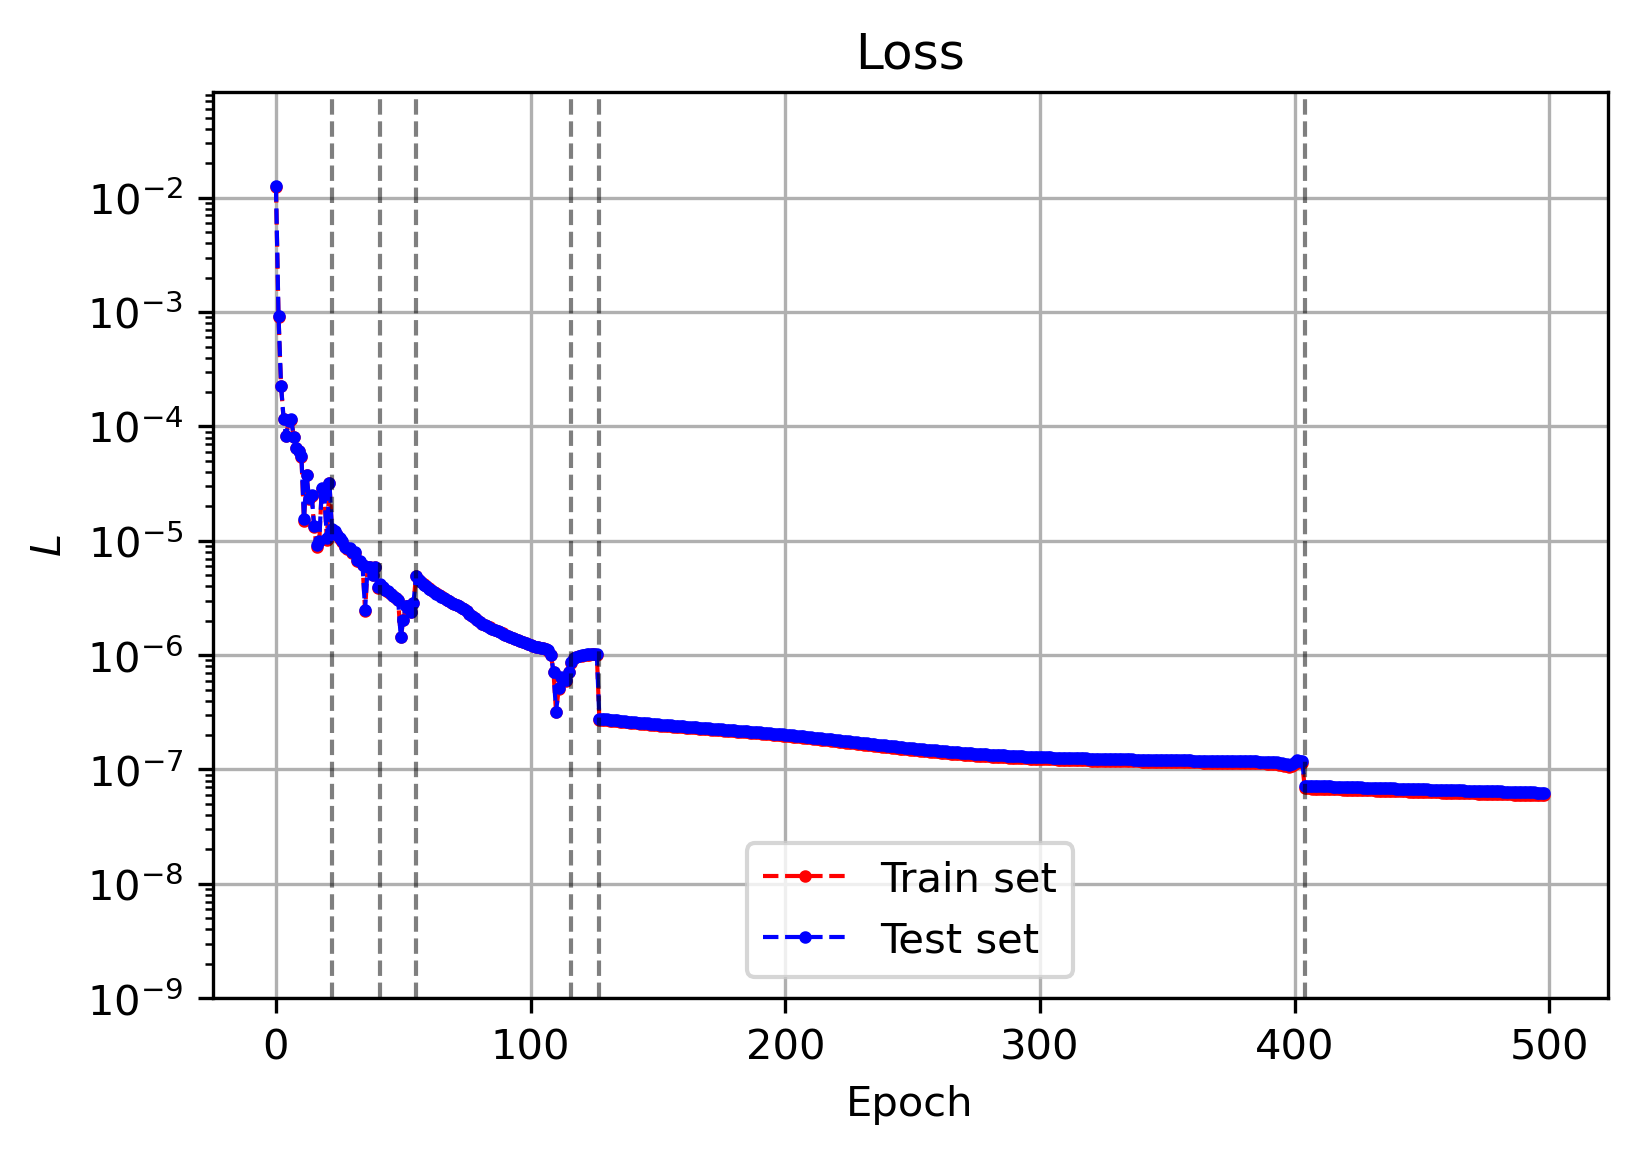

In [52]:
# Plot it
plt.figure()
lw = 1
ms = 2
plt.plot(train_losses, 'o--', color = 'red', label = 'Train set', lw = lw, ms = ms)
plt.plot(test_losses, 'o--', color = 'blue', label = "Test set", lw = lw, ms = ms)
plt.legend()
plt.grid()
plt.xlabel("Epoch")
xt_step = 100
xt = [i*xt_step for i in range(len(train_losses)//xt_step+2)]
plt.xticks(xt)
plt.ylabel(r'$L$')
plt.axhline(0, color = 'black', alpha = 0.7)
plt.title("Loss")
# Plot when we adapted learning rate
for t in adaptation_indices:
    plt.axvline(t, linestyle = "--", color = 'black', alpha = 0.5, lw = 1)
plt.yscale('log')
plt.ylim(10**(-9))
# plt.savefig("Plots/NNEOSC.pdf", bbox_inches = 'tight')
plt.show()

## Estimate the performance of the network

In [53]:
def L1_norm(predictions, y):
    """Here, predictions and y are arrays for one specific quantity, eg pressure. See table 1"""
    return sum(abs(predictions - y))/len(predictions)

In [54]:
def Linfty_norm(predictions, y):
    """Here, predictions and y are arrays for one specific quantity, eg pressure. See table 1"""
    return max(abs(predictions - y))

Get rho, chi and kappa back out of custom dataset objects:

In [55]:
# Get features and labels
test_features = test_data.features
test_labels = test_data.labels
test_features[:4]

[tensor([7.2904, 0.7552]),
 tensor([5.5853, 0.9099]),
 tensor([5.5768, 1.4810]),
 tensor([3.9533, 0.8353])]

In [56]:
with torch.no_grad():
    p_hat= np.array([])
    chi_hat = np.array([])
    kappa_hat = np.array([])
    for input_values in test_features:
        prediction = model(input_values)
        
        p_hat = np.append(p_hat, prediction[0].item())
        chi_hat = np.append(chi_hat, prediction[1].item())
        kappa_hat = np.append(kappa_hat, prediction[2].item())

In [57]:
# Get features as np arrays
rho = np.array([])
eps = np.array([])
for value in test_features:
    rho = np.append(rho, value[0].item())
    eps = np.append(eps, value[1].item())


# Get labels as np arrays
p = np.array([])
chi = np.array([])
kappa = np.array([])
for value in test_labels:
    p = np.append(p, value[0].item())
    chi = np.append(chi, value[1].item())
    kappa = np.append(kappa, value[2].item())

In [58]:
print(p[0])
print(p_hat[0])

3.6703102588653564
3.670281171798706


In [59]:
# Get the errors:
delta_p_L1 = L1_norm(p_hat, p)
delta_chi_L1 = L1_norm(chi_hat, chi)
delta_kappa_L1 = L1_norm(kappa_hat, kappa)

delta_p_Linfty = Linfty_norm(p_hat, p)
delta_chi_Linfty = Linfty_norm(chi_hat, chi)
delta_kappa_Linfty = Linfty_norm(kappa_hat, kappa)

In [60]:
print("Errors for p: %e  with L1 and %e with Linfty" % (delta_p_L1, delta_p_Linfty) )
print("Errors for chi: %e  with L1 and %e with Linfty" % (delta_chi_L1, delta_chi_Linfty) )
print("Errors for kappa: %e  with L1 and %e with Linfty" % (delta_kappa_L1, delta_kappa_Linfty) )

Errors for p: 2.537835e-04  with L1 and 7.740444e-03 with Linfty
Errors for chi: 1.092447e-04  with L1 and 2.209306e-03 with Linfty
Errors for kappa: 1.451482e-04  with L1 and 2.395774e-03 with Linfty


## Save the neural network if desired

In [109]:
# torch.save(model, 'NNEOSBv1_part2.pth')

Testing the loading of models

In [27]:
# test = torch.load('NNEOSBv0.pth')

# Archive


The following plots the difference between the train and test loss. However, I put it in the archive of this notebook, as the differences are usually very small and hence unimportant for practical aspects.

In [ ]:
# Get the difference (need np.array)
test_losses_as_array = np.array(test_losses)
train_losses_as_array = np.array(train_losses)
difference = test_losses_as_array - train_losses_as_array

# Plot it
plt.figure()
plt.plot(difference[20:], 'o--', color = 'red', label = "Difference", lw = 1, ms = 1.5)
plt.grid()
plt.xlabel("Epoch")
plt.ylabel(r'$L_{test} - L_{train}$')
plt.axhline(0, color = 'black', alpha = 0.7)
plt.title("Difference in losses")
# Plot when we adapted learning rate
# for t in adaptation_indices:
#     plt.axvline(t, color = 'black', alpha = 0.7)
plt.show()

## Line search to find the optimal learning rate parameter

For now, we are __not__ using a self-adaptive algorithm, but rather, we are going to do a line search to find the optimal value for the learning rate using a log scale as recommended by the book of Goodfellow. 

In [63]:
lr_list = [10**(-3), 10**(-4), 10**(-5), 10**(-6), 10**(-7)]
all_train_losses = []
all_test_losses = []

# Hyperparameters:
batch_size = 32
max_number_epochs = 100

for learning_rate in lr_list:
    ## Do a run: for one single learning rate
    
    # Make a new model, empty train and test loss arrays again
    model = NeuralNetwork().to(device)
    test_losses = []
    train_losses = []
    
    # Initialize the loss function
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # ----- Train the model -----
    print(f"Training the model with lr {learning_rate} . . .")
    for t in range(max_number_epochs):
        print(f"\n Epoch {t+1} \n --------------")
        # Train 
        train_loop(train_dataloader, model, loss_fn, optimizer)
        # Test on the training data
        average_train_loss = test_loop(train_dataloader, model, loss_fn)
        train_losses.append(average_train_loss)
        # Test on testing data
        average_test_loss = test_loop(test_dataloader, model, loss_fn)
        test_losses.append(average_test_loss)
        
    # ----- Train the model -----
    print('Finished a run')
    all_test_losses.append(test_losses)
    all_train_losses.append(train_losses)

    print("Done!")

Training the model with lr 0.001 . . .

 Epoch 1 
 --------------

 Epoch 2 
 --------------

 Epoch 3 
 --------------

 Epoch 4 
 --------------

 Epoch 5 
 --------------

 Epoch 6 
 --------------

 Epoch 7 
 --------------

 Epoch 8 
 --------------

 Epoch 9 
 --------------

 Epoch 10 
 --------------

 Epoch 11 
 --------------

 Epoch 12 
 --------------

 Epoch 13 
 --------------

 Epoch 14 
 --------------

 Epoch 15 
 --------------

 Epoch 16 
 --------------

 Epoch 17 
 --------------

 Epoch 18 
 --------------

 Epoch 19 
 --------------

 Epoch 20 
 --------------

 Epoch 21 
 --------------

 Epoch 22 
 --------------

 Epoch 23 
 --------------

 Epoch 24 
 --------------

 Epoch 25 
 --------------

 Epoch 26 
 --------------

 Epoch 27 
 --------------

 Epoch 28 
 --------------

 Epoch 29 
 --------------

 Epoch 30 
 --------------

 Epoch 31 
 --------------

 Epoch 32 
 --------------

 Epoch 33 
 --------------

 Epoch 34 
 --------------

 Epoch 35 
 -----


 Epoch 89 
 --------------

 Epoch 90 
 --------------

 Epoch 91 
 --------------

 Epoch 92 
 --------------

 Epoch 93 
 --------------

 Epoch 94 
 --------------

 Epoch 95 
 --------------

 Epoch 96 
 --------------

 Epoch 97 
 --------------

 Epoch 98 
 --------------

 Epoch 99 
 --------------

 Epoch 100 
 --------------
Finished a run
Done!
Training the model with lr 1e-06 . . .

 Epoch 1 
 --------------

 Epoch 2 
 --------------

 Epoch 3 
 --------------

 Epoch 4 
 --------------

 Epoch 5 
 --------------

 Epoch 6 
 --------------

 Epoch 7 
 --------------

 Epoch 8 
 --------------

 Epoch 9 
 --------------

 Epoch 10 
 --------------

 Epoch 11 
 --------------

 Epoch 12 
 --------------

 Epoch 13 
 --------------

 Epoch 14 
 --------------

 Epoch 15 
 --------------

 Epoch 16 
 --------------

 Epoch 17 
 --------------

 Epoch 18 
 --------------

 Epoch 19 
 --------------

 Epoch 20 
 --------------

 Epoch 21 
 --------------

 Epoch 22 
 -----------